In [1]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import re
import glob

In [2]:
# Read in Data:
data = []
for excel_path in glob.glob("EnergieUebersichtCH-*"):
    data.append(pd.read_excel(excel_path, sheet_name='Zeitreihen0h15'))

data = pd.concat(data, axis=0, ignore_index=True)

In [4]:
data.head()

,Unnamed: 0,Summe endverbrauchte Energie Regelblock Schweiz\nTotal energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz\nTotal energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz\nNet outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz\nGrid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie\nPositive secundary control energy,Negative Sekundär-Regelenergie\nNegative secundary control energy,Positive Tertiär-Regelenergie\nPositive tertiary control energy,Negative Tertiär-Regelenergie\nNegative tertiary control energy,...,"Produktion Kantone OW, NW, UR\nProduction Cantons OW, NW, UR","Verbrauch Kantone OW, NW, UR\nConsumption Cantons OW, NW, UR","Produktion Kantone GE, VD\nProduction Cantons GE, VD","Verbrauch Kantone GE, VD\nConsumption Cantons GE, VD","Produktion Kantone SH, ZH\nProduction Cantons SH, ZH","Verbrauch Kantone SH, ZH\nConsumption Cantons SH, ZH",Produktion Kantonsübergreifend\nProduction across Cantons,Verbrauch Kantonsübergreifend\nConsumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete\nProduction control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete\nConsumption control area CH - foreign territories
0,Zeitstempel,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01 00:15:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01 00:30:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01 00:45:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01 01:00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Some Data Cleaning:
data.set_index('Unnamed: 0', drop=True, inplace=True)
data = data[data.index != 'Zeitstempel']
data.index.name = 'Zeitstempel'
data.index = pd.to_datetime(data.index)
data = data.iloc[:, :5]
data.columns = [re.sub("\\n.*",'',x) for x in data.columns.to_list()]
data.head()

# For Faster Processing use daily data:
data = data.resample('D').mean()

In [6]:
# Some Feature creation
data['Strombudget Schweiz'] = data['Summe produzierte Energie Regelblock Schweiz'] + data['Vertikale Einspeisung ins Übertragungsnetz Schweiz']
data['Stromverbrauch Schweiz'] = data['Summe endverbrauchte Energie Regelblock Schweiz'] + data['Netto Ausspeisung aus dem Übertragungsnetz Schweiz']
data['Strombilanz Schweiz'] = data['Strombudget Schweiz'] - data['Stromverbrauch Schweiz']

In [7]:
# There are some Nans when we switch from Winter-Time to Summer-Time (This is only relevant for a resultion up to hourly data)
print(data[data['Stromverbrauch Schweiz'].isna()].index)
# To fix, we just take the value after to avoid leakage:
data = data.bfill()

DatetimeIndex(['2021-01-12', '2021-02-11', '2021-02-12', '2021-03-11',
               '2021-03-12', '2021-04-11', '2021-04-12', '2021-05-11',
               '2021-05-12', '2021-06-11', '2021-06-12', '2021-07-11',
               '2021-07-12', '2021-08-11', '2021-08-12', '2021-09-11',
               '2021-09-12', '2021-10-11', '2021-10-12', '2021-11-11',
               '2021-11-12', '2021-11-13', '2021-11-14', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-20', '2021-11-21', '2021-11-22', '2021-11-23',
               '2021-11-24', '2021-11-25', '2021-11-26', '2021-11-27',
               '2021-11-28', '2021-11-29', '2021-11-30'],
              dtype='datetime64[ns]', name='Zeitstempel', freq=None)


In [9]:
data.head()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz,Strombilanz Schweiz
Zeitstempel,,,,,,,,
2009-01-01,1.507474e+06,1.303196e+06,1.714727e+06,365860.064147,1.007370e+06,2.310566e+06,1.873334e+06,4.372318e+05
2009-01-02,1.605925e+06,1.383252e+06,1.781340e+06,357982.217260,1.078031e+06,2.461283e+06,1.963907e+06,4.973761e+05
2009-01-03,1.676399e+06,1.607007e+06,1.815626e+06,172117.649896,1.287807e+06,2.894815e+06,1.848517e+06,1.046298e+06
2009-01-04,1.611144e+06,1.453839e+06,1.763500e+06,270269.789812,1.158403e+06,2.612242e+06,1.881414e+06,7.308279e+05
2009-01-05,1.956470e+06,1.860050e+06,2.115823e+06,240557.496729,1.476867e+06,3.336917e+06,2.197028e+06,1.139889e+06


In [10]:
data.describe()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz,Strombilanz Schweiz
count,4.727000e+03,4.727000e+03,4.727000e+03,4.727000e+03,4.727000e+03,4.727000e+03,4.727000e+03,4.727000e+03
mean,1.619572e+06,1.813412e+06,1.803883e+06,1.764563e+05,1.311715e+06,3.125126e+06,1.796028e+06,1.329098e+06
std,2.389895e+05,3.315680e+05,2.159690e+05,1.819685e+05,2.709563e+05,5.963399e+05,3.594631e+05,7.629296e+05
min,1.071808e+06,8.305612e+05,1.247532e+06,0.000000e+00,5.390962e+05,1.369657e+06,1.071808e+06,-1.319107e+06
25%,1.471308e+06,1.574848e+06,1.666017e+06,5.183423e+03,1.122729e+06,2.696199e+06,1.525575e+06,7.744301e+05
50%,1.600366e+06,1.795553e+06,1.774235e+06,1.287599e+05,1.300113e+06,3.095608e+06,1.741215e+06,1.306335e+06
75%,1.785822e+06,2.034470e+06,1.947636e+06,2.949830e+05,1.493718e+06,3.519506e+06,2.089401e+06,1.873812e+06
max,2.317664e+06,3.075939e+06,2.473519e+06,1.101302e+06,2.309130e+06,5.385068e+06,3.097613e+06,3.917201e+06


<AxesSubplot:title={'center':'Strombudget Schweiz'}, xlabel='Zeitstempel', ylabel='kWH'>

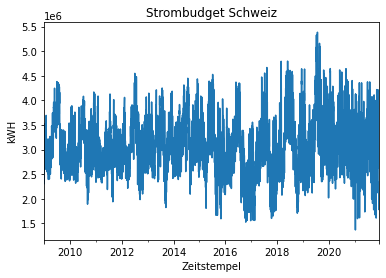

In [11]:
data['Strombudget Schweiz'].plot.line(ylabel='kWH', title='Strombudget Schweiz')

<AxesSubplot:xlabel='Zeitstempel'>

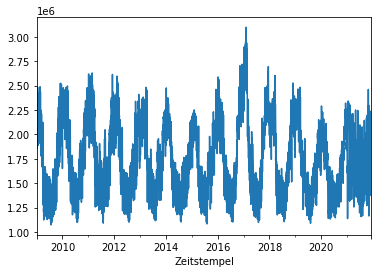

In [12]:
data['Stromverbrauch Schweiz'].plot.line()

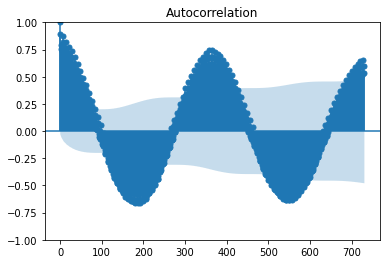

In [13]:
plot_acf(data['Stromverbrauch Schweiz'], lags=2*365)
plt.show()

<AxesSubplot:xlabel='Zeitstempel'>

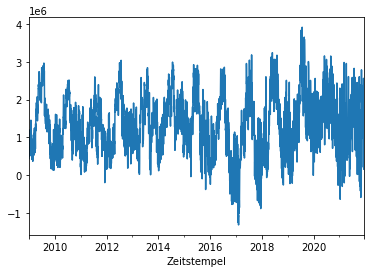

In [14]:
data['Strombilanz Schweiz'].plot.line()

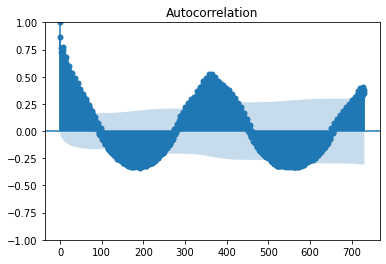

In [15]:
plot_acf(data['Strombilanz Schweiz'], lags=2*365)
plt.show()

Text(0.5, 1.0, 'Series vs. Lag 1')

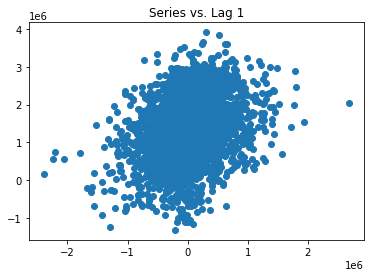

In [16]:
data['Strombilanz Schweiz lag 1'] = data['Strombilanz Schweiz'].shift(1)
data['Strombilanz - Lag 1'] = data['Strombilanz Schweiz'] - data['Strombilanz Schweiz lag 1']
data_ = data.dropna()
plt.scatter(data_['Strombilanz - Lag 1'], data_['Strombilanz Schweiz'])
plt.title('Series vs. Lag 1')

In [17]:
from sklearn.metrics import r2_score
from scipy import stats
r2_score(data_['Strombilanz Schweiz lag 1'], data_['Strombilanz Schweiz'])

0.7395906062210004

In [18]:
r2_scores = []
lags = []
corrs = []
for i in range(1, 2*365, 15):
    lags.append(i)
    data_tmp = data.copy()
    data_tmp['Strombilanz Schweiz Lag'] = data_tmp['Strombilanz Schweiz'].shift(i)
    data_tmp.dropna(inplace=True)
    r2_scores.append(r2_score(data_tmp['Strombilanz Schweiz Lag'], data_tmp['Strombilanz Schweiz']))
    corrs.append(stats.pearsonr(data_tmp['Strombilanz Schweiz Lag'], data_tmp['Strombilanz Schweiz'])[0])

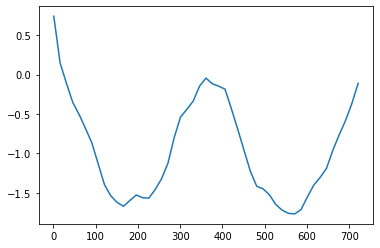

In [19]:
plt.plot(lags, r2_scores)

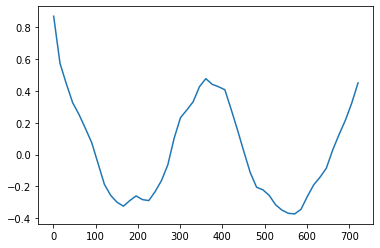

In [20]:
plt.plot(lags, corrs)

<AxesSubplot:>

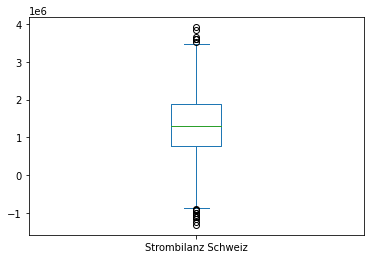

In [21]:
data_['Strombilanz Schweiz'].plot.box()

<AxesSubplot:ylabel='Frequency'>

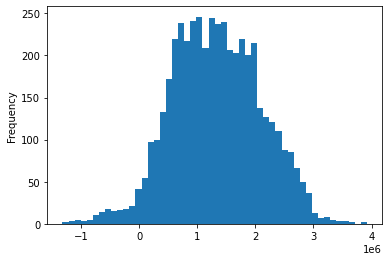

In [22]:
data_['Strombilanz Schweiz'].plot.hist(bins=50)

In [23]:
data_['Strombilanz Schweiz'].describe()

count    4.726000e+03
mean     1.329287e+06
std      7.629000e+05
min     -1.319107e+06
25%      7.748663e+05
50%      1.306502e+06
75%      1.873819e+06
max      3.917201e+06
Name: Strombilanz Schweiz, dtype: float64

In [24]:
data_below_0 = data.query('`Strombilanz Schweiz` < 0')
data_below_0

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz,Strombilanz Schweiz,Strombilanz Schweiz lag 1,Strombilanz - Lag 1
Zeitstempel,,,,,,,,,,
2011-12-08,1.874940e+06,1.400442e+06,2.108177e+06,738533.625292,1.014022e+06,2.414464e+06,2.613473e+06,-199008.987375,616597.119990,-815606.107365
2015-04-05,1.379379e+06,1.122280e+06,1.592128e+06,446518.824031,6.871575e+05,1.809437e+06,1.825897e+06,-16460.189969,198924.292562,-215384.482531
2015-04-06,1.429755e+06,1.147515e+06,1.622553e+06,455898.205594,6.987666e+05,1.846282e+06,1.885653e+06,-39371.301365,-16460.189969,-22911.111396
2015-09-12,1.334345e+06,1.020555e+06,1.480239e+06,429046.637065,6.469797e+05,1.667535e+06,1.763392e+06,-95857.153793,573814.818758,-669671.972550
2015-10-31,1.483377e+06,1.014480e+06,1.626923e+06,583969.553245,6.720832e+05,1.686563e+06,2.067346e+06,-380782.726172,371877.452908,-752660.179081
...,...,...,...,...,...,...,...,...,...,...
2021-10-27,1.747372e+06,1.330133e+06,1.901343e+06,545464.719026,9.333333e+05,2.263467e+06,2.292837e+06,-29370.652916,186272.537336,-215643.190252
2021-10-28,1.753796e+06,1.207000e+06,1.945633e+06,706229.890612,8.110579e+05,2.018058e+06,2.460026e+06,-441967.852630,-29370.652916,-412597.199714
2021-10-29,1.738220e+06,1.201215e+06,1.914595e+06,680714.578429,8.108026e+05,2.012017e+06,2.418934e+06,-406916.893018,-441967.852630,35050.959612


<AxesSubplot:xlabel='Zeitstempel'>

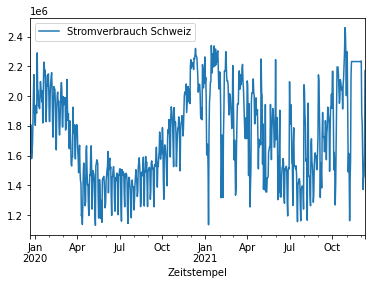

In [32]:
data[['Stromverbrauch Schweiz']].tail(720).plot.line()

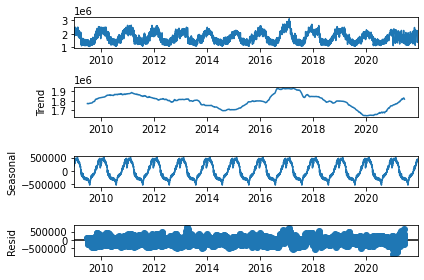

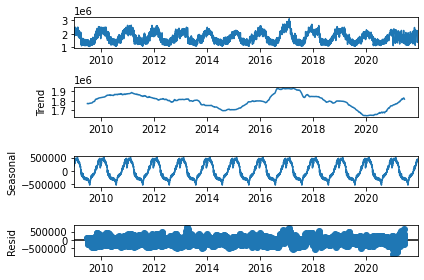

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose


analysis = data[['Stromverbrauch Schweiz']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="additive", period=365)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [33]:
residual[residual.isna()]

Zeitstempel
2009-01-01   NaN
2009-01-02   NaN
2009-01-03   NaN
2009-01-04   NaN
2009-01-05   NaN
              ..
2021-12-06   NaN
2021-12-07   NaN
2021-12-08   NaN
2021-12-09   NaN
2021-12-10   NaN
Name: resid, Length: 364, dtype: float64

<AxesSubplot:ylabel='Frequency'>

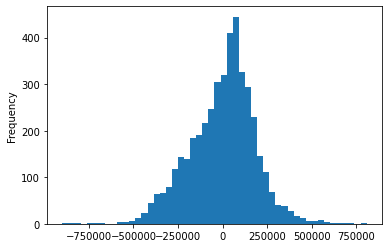

In [194]:
residual.plot.hist(bins=50)

In [51]:
def calc_num_quantiles(data):
    """
    data: pandas data frame
    
    returns: each quantile in the data
    """
    num_quantiles = len(data)
    return np.linspace(0, 1, num = num_quantiles)

def calc_dist_args(dist, data):
    """
    dist: scipy.stats distribution
    data: pandas data frame
    
    returns: fitted arguments of the provided distribution for the data
    """
    distargs = dist.fit(data)
    distargs = distargs[:len(distargs)-2]
    return distargs

def calculate_m_b(x, y):
    # m and b is needed for linear regression
    """
    x, y: 
    """
    y = y[np.isinf(x)==False]
    x = x[np.isfinite(x)]
    n = len(x)
    m = np.divide((n * np.sum(np.multiply(x, y)) - np.sum(x) * np.sum(y)),
                     (n * np.sum(np.square(x)) - np.square(np.sum(x))))
    b = np.divide(np.sum(np.square(x)) * np.sum(y) - np.sum(x) * np.sum(x * y),
                     (n * np.sum(np.square(x)) - np.square(np.sum(x))))
    # R2 of regression slope
    y_regressed = x * m + b
    y_mean = np.sum(y)/n
    r2error = np.sum(np.square(y_regressed-y))
    r2error /= np.sum(np.square(y-y_mean))
    
    return m, b, 1 - r2error

def qq(data, dist):
    """
    
    """
    
    #Log data if dist.lognorm == True
    is_log_norm = False
    if dist == stats.lognorm:
        data = np.log(data)
        dist = stats.norm
        is_log_norm = True
        
    #Anzahl Quantile berechnen
    distargs = calc_dist_args(dist, data)
    quantile_list = calc_num_quantiles(data)


    #Bereiche unter der Kurve bestimmen, die eine gleichgrosse Wahrscheinlichkeit haben
    quantile_distribution = dist.ppf(quantile_list, *distargs, loc = 0, scale = 1)
    
    #Linearen Fit berechnen
    m, b, r2_score = calculate_m_b(quantile_distribution[:-1], data[:-1])

    if is_log_norm:
        dist = stats.lognorm
        
    #print(quantile_list)
    #print(quantile_distribution)
    #print(np.quantile(zone1['mass'], quantile_list))
    return r2_score, dist, m, b

def loop_qq(dists, data):
    """
    creates qq plots for multiple distributions at once and displays them.
    
    dists: list of scipy.stats distrubutions
    data: pandas data frame
    
    returns:
    
    r2_best: best r2score
    best_dist: distribution with best r2 score
    r2_list: list of r2 scores
    unusable_dist: list of distributions the function was unable to fit
    error_messages: eventual error messages for the distributions
    distargs: the fitted distributions arguments
    """
    r2_best = 0
    best_dist = "All suck lmao"
    best_plt = ""
    data = np.sort(data)
    
    #Generate highiq plots
    
    r2_list = []
    distributions = []
    ms = []
    bs = []
    unusable_dist = []
    error_messages = []
    distargs = []
    
    for dist in dists:
        try:
            r2_now, dist_now, m, b = qq(data, dist)
            r2_list.append(r2_now)
            distributions.append(dist)
            ms.append(m)
            bs.append(b)
            if r2_now > r2_best:
                r2_best = r2_now
                best_dist = dist_now
        except Exception as e:
            error_messages.append(e)
            unusable_dist.append(dist.name)
            continue

    print("Best dist:", best_dist.name)
    data_to_sort = np.column_stack((r2_list, distributions, ms, bs))
    data_sorted = data_to_sort[np.argsort(-data_to_sort[:,0])]
    
    quantile_list = calc_num_quantiles(data)
    n_data = len(distributions)
    nr_row_col = int(np.ceil(np.sqrt(n_data)))
    
    row = 0 
    col = 0
    fig, axes = plt.subplots(nr_row_col, nr_row_col, figsize = [nr_row_col*5,nr_row_col*5])
    
    for r2_score, distribution, m, b in data_sorted:
        is_log_norm = False
        if distribution == stats.lognorm:
            distribution = stats.norm
            data = np.log(data)
            is_log_norm = True
            
        distargs_fit = calc_dist_args(distribution, data)    
        quantile_distribution = distribution.ppf(quantile_list, *distargs_fit, loc = 0, scale = 1)
        distargs.append(distargs_fit)

        if not is_log_norm:
            axes[col, row].scatter(quantile_distribution, data)
            axes[col, row].plot(quantile_distribution[:-1], quantile_distribution[:-1] * m + b)
            axes[col, row].set_title('Verteilung: ' + str(distribution.name)+ ' .R2-score: ' + str(np.round(r2_score,3)) + '\nParameter: ' + str(np.round(distargs_fit, 3)))
        else:
            axes[col, row].scatter(quantile_distribution, data)
            axes[col, row].plot(quantile_distribution[:-1], quantile_distribution[:-1] * m + b)
            axes[col, row].set_title('Verteilung: ' + str(stats.lognorm.name) + ' .R2-score: ' + str(np.round(r2_score,3)) + '\nParameter: ' + str(np.round(distargs_fit, 3)))
            distribution = stats.lognorm
            data = np.exp(data)
        
        row += 1
        if row == nr_row_col:
            col += 1
            row = 0

        
    return r2_best, best_dist, r2_list, unusable_dist, error_messages, distargs

In [166]:
def mean_excess_function(series, threshold):

    me = np.sum((series-threshold)) / np.sum(np.where(series > threshold, 1, 0))

    return me


In [167]:
mean_excess_function(residual.dropna(), 50000)

-117020.33609570806

In [207]:
mes = []
thress = []
for thres in np.linspace(0, residual.max()*2, 200):
    thress.append(thres)
    mes.append(mean_excess_function(residual.dropna(), thres))

C:\Users\vince\AppData\Local\Temp/ipykernel_14772/1694940441.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  me = np.sum((series-threshold)) / np.sum(np.where(series > threshold, 1, 0))


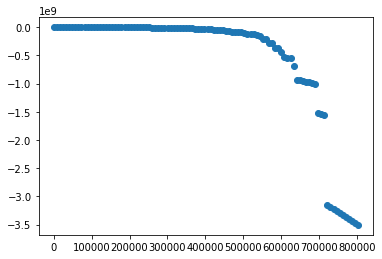

In [208]:
plt.scatter(thress, mes)

In [189]:
def hill_schaetzer(series, k):
    assert k >= 2
    series = np.sort(series)[::-1]
    xi = 0
    for j in range(1, k+1):
        xi += np.log(series[j] / series[k])
    return xi / k

In [200]:
hill_schaetzer(residual.dropna(), 200)

0.2699543390113257

In [196]:
xis = []
ks = []
for k in range(2, 4363):
    ks.append(k)
    xis.append(hill_schaetzer(residual.dropna(), k))

C:\Users\vince\AppData\Local\Temp/ipykernel_14772/153288786.py:6: RuntimeWarning: invalid value encountered in log
  xi += np.log(series[j] / series[k])


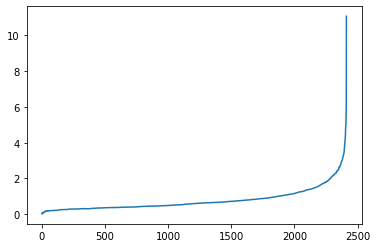

In [197]:
plt.plot(ks, xis)

In [52]:
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.randint, stats.bernoulli, stats.hypergeom, stats.binom, stats.cauchy, stats.t, stats.f, stats.poisson,
         stats.norm,stats.chi2, stats.beta,stats.uniform, stats.nbinom, stats.geom, stats.lognorm, stats.gamma, 
         stats.expon, stats.logistic, stats.pareto, stats.laplace]

C:\Users\vince\anaconda3\envs\SPZ\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\vince\anaconda3\envs\SPZ\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\vince\anaconda3\envs\SPZ\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\vince\AppData\Local\Temp/ipykernel_14772/2274346076.py:49: RuntimeWarning: invalid value encountered in log
  data = np.log(data)


Best dist: t


C:\Users\vince\anaconda3\envs\SPZ\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\vince\anaconda3\envs\SPZ\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\vince\anaconda3\envs\SPZ\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\vince\anaconda3\envs\SPZ\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


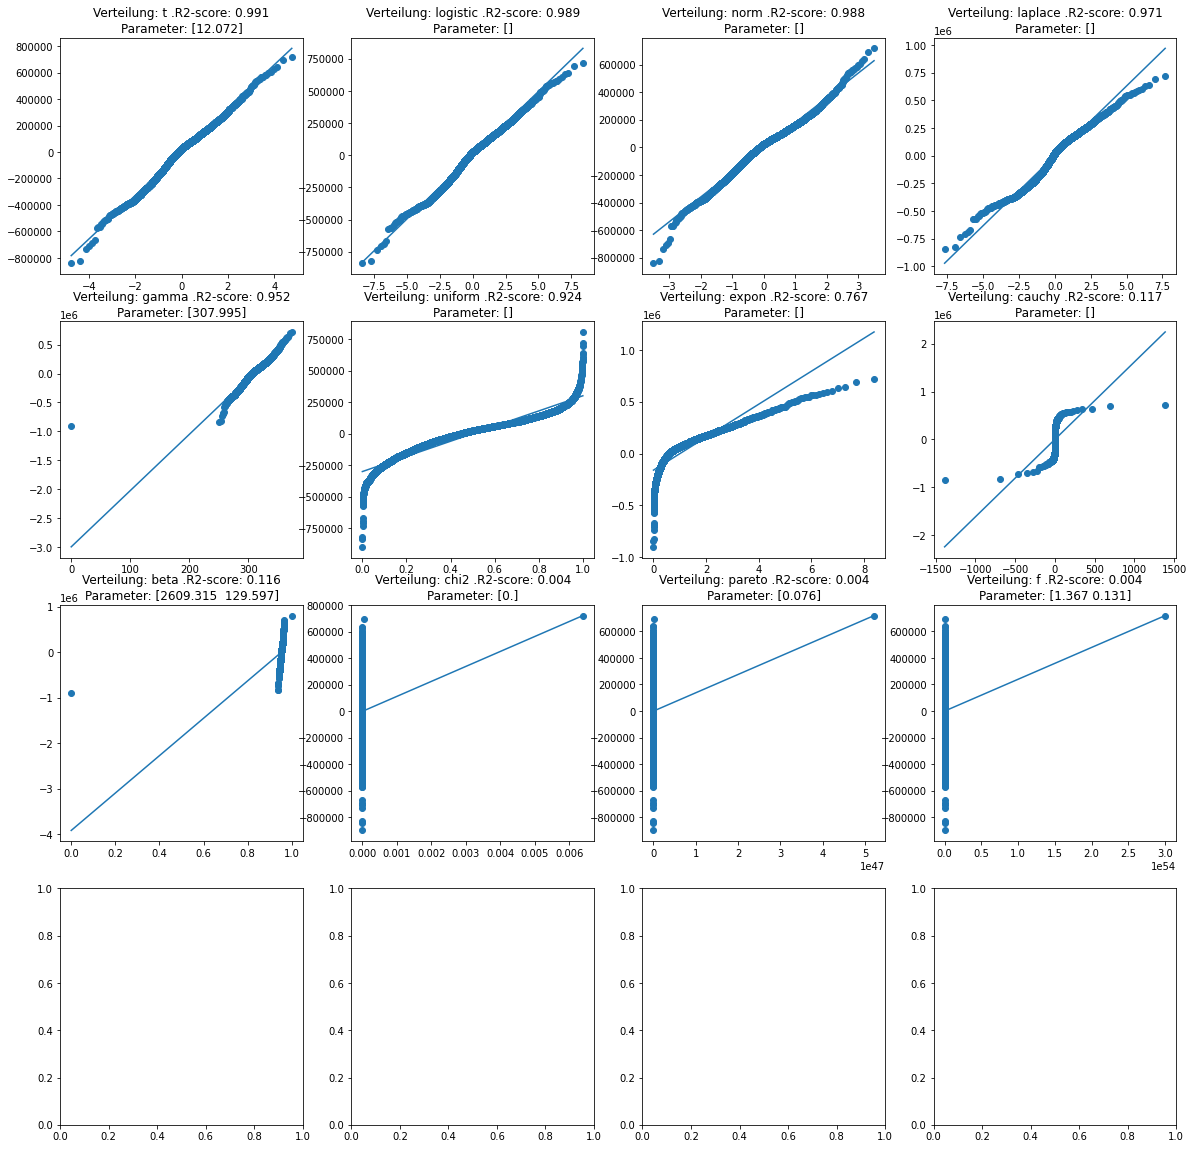

In [53]:
best_r2_score, best_dist, r2_score, unusable_dist, error_messages, distargs = loop_qq(dists, residual.dropna())

In [126]:
# fit parameters to data
PERCENT_OF_VALUES = 0.9999
distargs = best_dist.fit(residual.dropna())

#generate sample with same parameters as input data
sample = best_dist.rvs(*distargs, size = 10000)
sample

array([-260999.35811798,  129741.24386287, -144510.52523487, ...,
        131688.36867108, -247153.80498447,   51947.36733538])

In [127]:
distargs

(12.071535657763246, 3871.6740582865423, 165525.9510977566)

<AxesSubplot:ylabel='Frequency'>

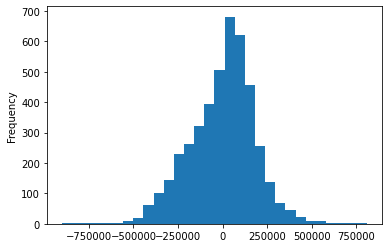

In [128]:
residual.dropna().plot.hist(bins=30)

In [144]:
f"In {100*PERCENT_OF_VALUES}% of Days the usage will fall between {best_dist.interval(PERCENT_OF_VALUES, *distargs)}. Values outside of this area will happen every {1/(1-PERCENT_OF_VALUES)} Days."

'In 99.99% of Days the usage will fall between (-936337.7611382168, 944081.10925479). Values outside of this area will happen every 10000.0000000011 Days.'

In [136]:
# fit parameters to data
KWH = 1e6
distargs = best_dist.fit(residual.dropna())

In [138]:
best_dist.cdf(KWH, *distargs)

0.9999705054648296

In [143]:
f"Every {1/(1-best_dist.cdf(KWH, *distargs))} Days we can except to see an usage above {KWH}. It corresponds to a chance of {(1-best_dist.cdf(KWH, *distargs))*100}%."

'Every 33904.585857066435 Days we can except to see an usage above 1000000.0. It corresponds to a chance of 0.0029494535170426772%.'